We have already a mlmodel to have a good estimation of when to buy or sell(roughly) we want to optimize the best strategy based on those predictions.

The strategy should include:
  - stop_loss_pct
  - take_profit_pct
  

In [1]:

from src.core.backtest.backtesting import backtest_numba

In [3]:
#Deserialize
import pickle
import pandas as pd
from src.modules.paths import get_project_root
from src.core.features.utils import feature_pipeline, add_domain_features
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
with open("wow_20_until_2021_10_23.pickle" ,'rb') as f:
    model = pickle.load(f)
import optuna
import numpy as np

In [4]:
cut_off_date ="2021-11-07 21:28:00"
#cut_off_date ="2021-09-07 21:28:00"
#cut_off_date ="2021-10-23 21:28:00"
crypto_to_optimize=["bcheur","compeur","xdgeur","xlmeur"]
crypto_to_evaluate = ["etheur", "algoeur", "bateur", "adaeur","xrpeur"]
columns_features = [col for col in feature_pipeline(pd.read_csv(get_project_root() / "data" / "historical" / "etheur.csv"), include_target=False)[0].columns if col.startswith("feature")]

In [5]:



df_all = pd.read_feather(get_project_root() / "data" / "training" / "training_all_crypto_28_11_2021.feather")
df = df_all[df_all.date>cut_off_date].copy()

In [6]:
crypto_to_optimize

['bcheur', 'compeur', 'xdgeur', 'xlmeur']

adaeur
algoeur
bateur
bcheur
compeur
etheur
xdgeur
xlmeur
xrpeur

In [19]:
sampler = optuna.samplers.RandomSampler(seed=1)
def objective(trial):
    # 1. Suggest values of the hyperparameters using a trial object.
    param = {
        'take_profit_pct': trial.suggest_float('take_profit_pct', 1e-8, 0.2),
        'stop_loss_pct': trial.suggest_float('stop_loss_pct', 1e-8, 0.2),
        "lim_pred_buy": trial.suggest_float('lim_pred_buy', -10, -3),
    }
    list_metric = []
    number_actions = []
    for name, df_group in df.groupby("pair_name"):
        #print(name)
        actions = backtest_numba(
            indexes= df_group.time.values,
            open_values=df_group.open.values,
            preds_values=df_group.preds.values,
            **param
        )
        actions_df = pd.DataFrame(actions, columns=["index", "action", "cost", "comment"])
        number_actions.append(actions_df.shape[0])
        profit = actions_df["cost"].sum()/df_group["open"].mean()
        hist_ratio = df_group.tail(1).open.values[0]/df_group.head(1).open.values[0]-1
        list_metric.append(profit)#-hist_ratio)
        if name=="bateur" and profit>20:
            print(actions)
            print(actions_df)
            print(list_metric)
            print(np.array(list_metric).mean())
            break
        
    
    
    #print(param)
    #print(list_metric)
    mean_metrics=np.array(list_metric).mean()
    #print(mean_metrics)
    if mean_metrics>20:
        print("-"*40)
        print(actions)
        print(profit, hist_ratio)
        print(list_metric)
    return mean_metrics #* np.array(number_actions).mean()/1000

# 3. Create a study object and optimize the objective function.
df["preds"] = model.predict(df[columns_features])
optuna.logging.set_verbosity("WARNING")
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000)

In [20]:
study.best_params, study.best_value

({'take_profit_pct': 0.049103743582114695,
  'stop_loss_pct': 0.18220384882120128,
  'lim_pred_buy': -9.695260153695642},
 -0.01584392720957347)

In [67]:
# how does it look

         time  action        cost  comment
0  1636579260       0 -3992.41604        0
1  1636648500       1  4150.34196        1
2  1637034480       0 -3811.18400        0
3  1637844720       1  3950.30532        1
0.07623359069904143


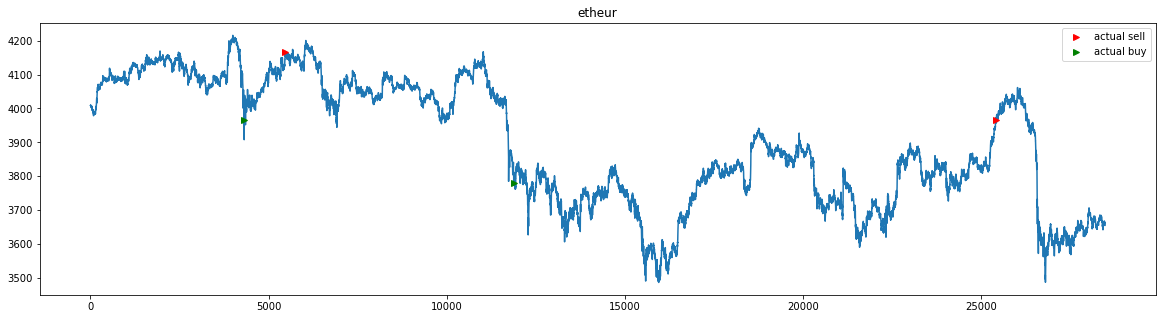

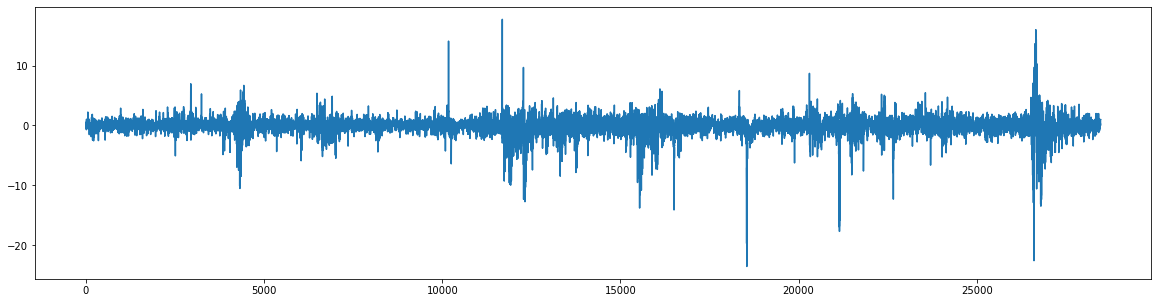

          time  action      cost  comment
0   1636382700       0 -1.710926        0
1   1636394220       1  1.781844        1
2   1636574820       0 -1.857400        0
3   1636690320       1  1.925427        1
4   1636718700       0 -1.866787        0
5   1636719480       1  1.915975        1
6   1636729440       0 -1.956174        0
7   1636733220       1  2.024629        1
8   1636734780       0 -1.983543        0
9   1637021520       1  1.579596        2
10  1637024760       0 -1.522305        0
11  1637209560       1  2.028185        1
12  1637222820       0 -1.701680        0
13  1637232360       1  1.760799        1
0.25398662307642844


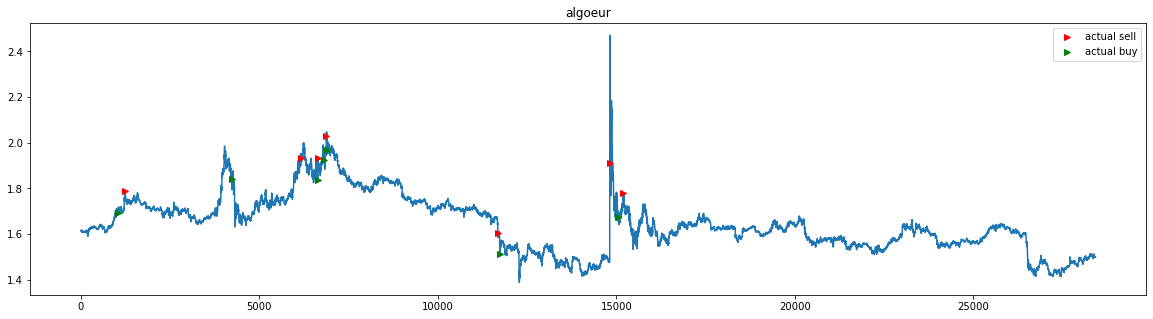

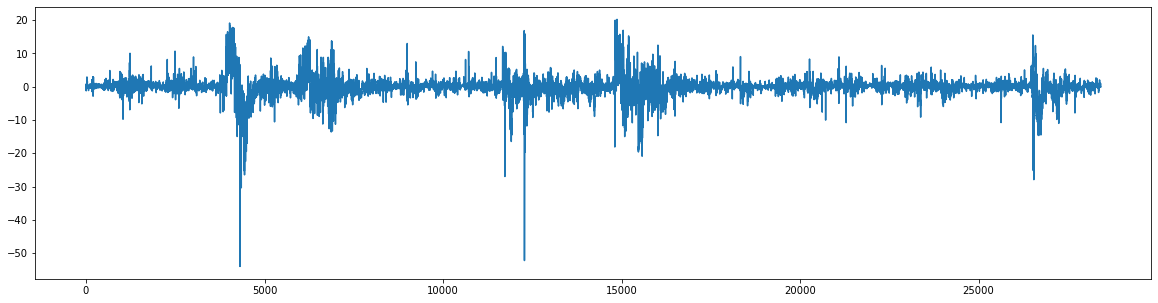

          time  action      cost  comment
0   1636386900       0 -0.889263        0
1   1636387200       1  0.926280        1
2   1636441020       0 -1.055636        0
3   1636460880       1  1.111446        1
4   1636480140       0 -1.037162        0
5   1637255460       1  0.837158        2
6   1637376540       0 -0.997946        0
7   1637811660       1  1.032085        1
8   1637857860       0 -1.230543        0
9   1637882700       1  1.263785        1
10  1637907540       0 -1.516803        0
11  1637910120       1  1.570712        1
12  1637914920       0 -1.441583        0
13  1638017520       1  1.459140        1
0.0313365949581508


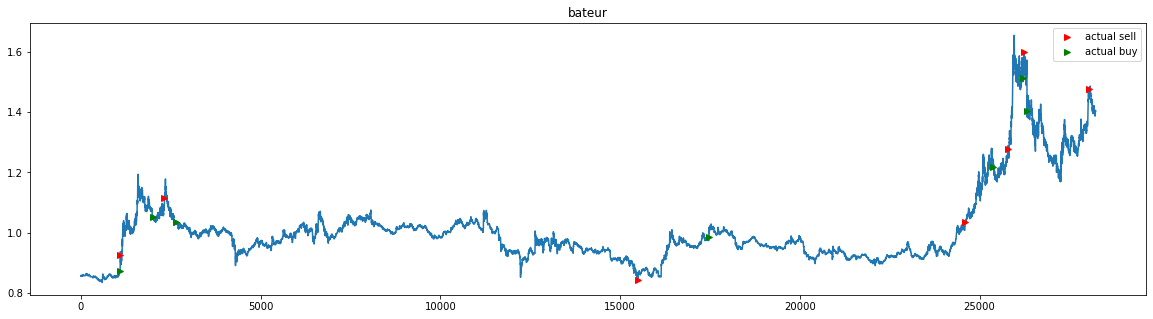

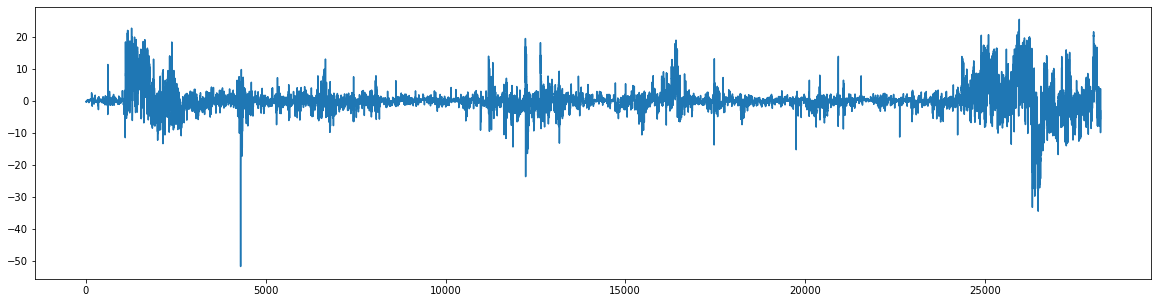

         time  action      cost  comment
0  1636577460       0 -1.841539        0
1  1637724420       1  1.489916        2
2  1637763780       0 -1.444277        0
3  1637769300       1  1.488168        1
-0.18306905335580742


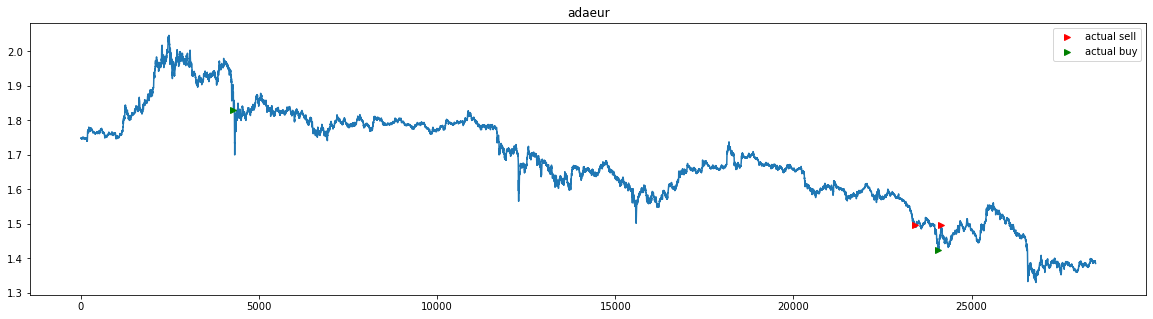

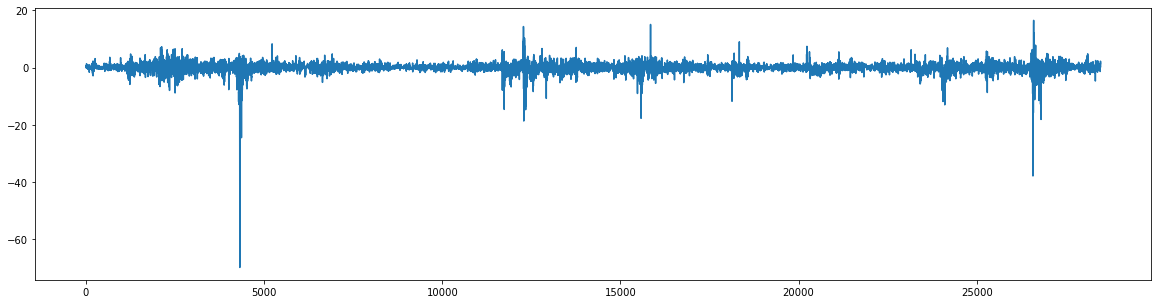

         time  action      cost  comment
0  1636549500       0 -1.114440        0
1  1636564860       1  1.158796        1
2  1636577460       0 -1.077192        0
3  1637914680       1  0.868512        2
-0.16645393241835726


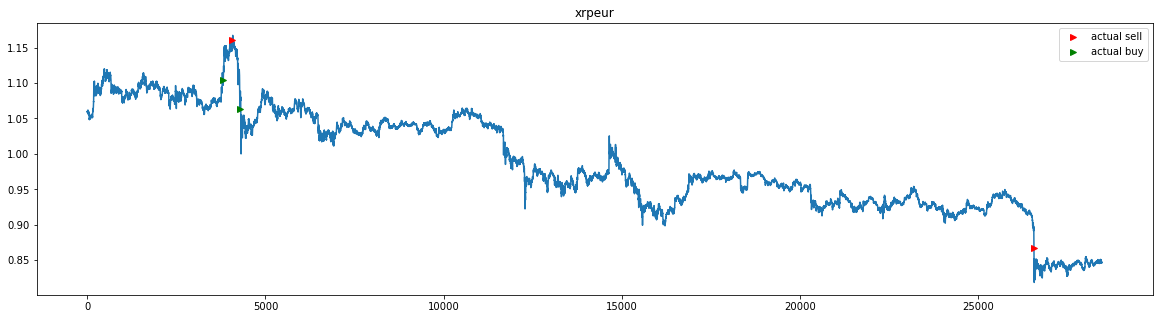

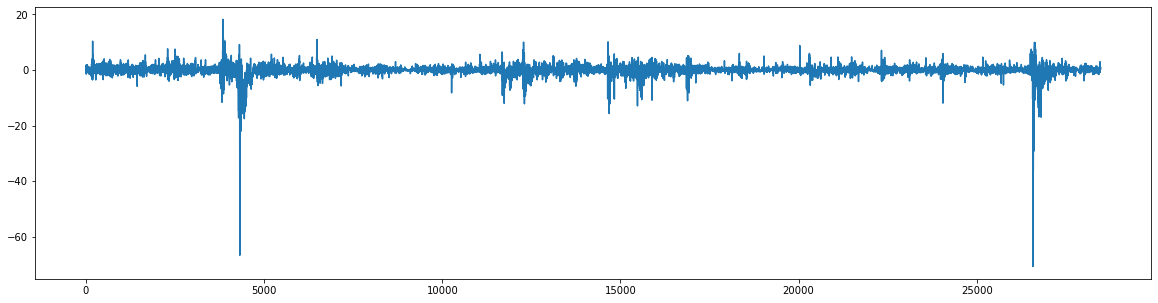

         time  action       cost  comment
0  1636579500       0 -574.40848        0
1  1636622400       1  589.21368        1
2  1637061120       0 -532.67220        0
3  1637800200       1  554.66244        1
0.06781392286783347


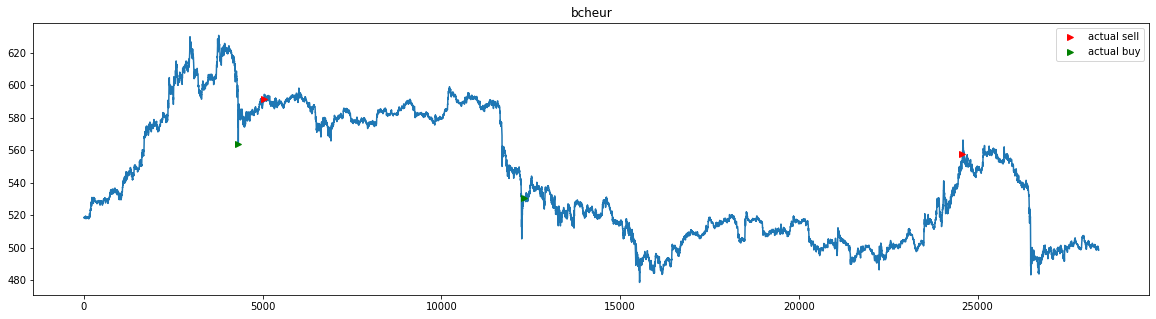

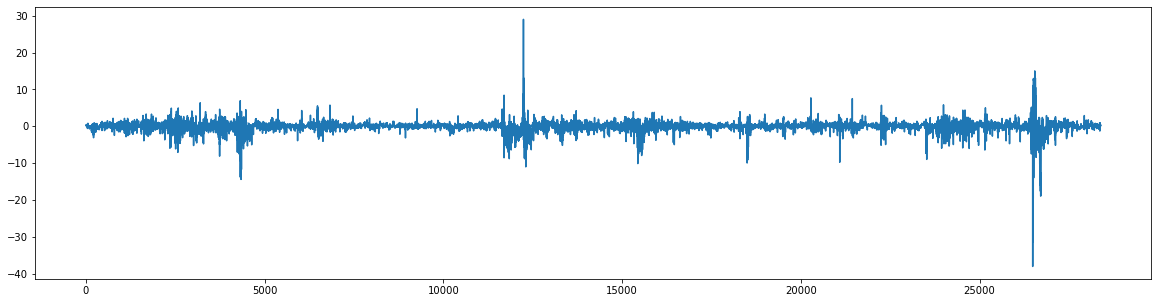

         time  action       cost  comment
0  1636577460       0 -293.56960        0
1  1636827900       1  303.52104        1
2  1637060160       0 -273.94140        0
3  1637150340       1  284.64684        1
4  1637914920       0 -227.22528        0
5  1637973540       1  236.11176        1
0.10590924191070722


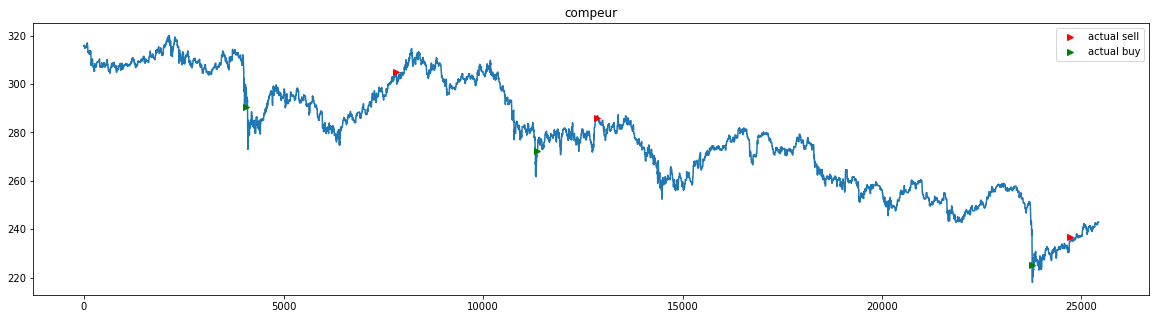

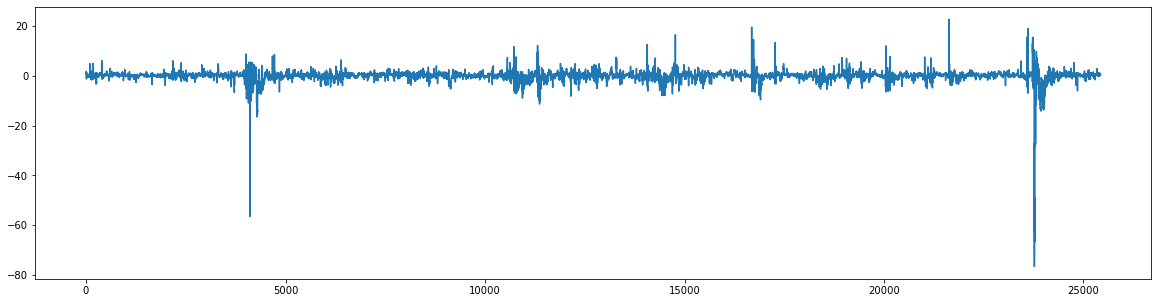

         time  action      cost  comment
0  1636361280       0 -0.252568        0
1  1637057400       1  0.203890        2
2  1637057460       0 -0.205514        0
3  1637072220       1  0.214089        1
4  1637249160       0 -0.196625        0
5  1637328480       1  0.204062        1
-0.15338540672772352


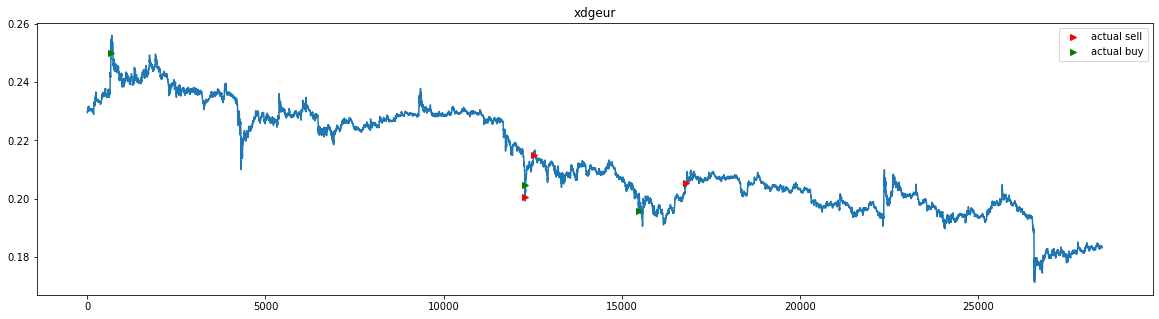

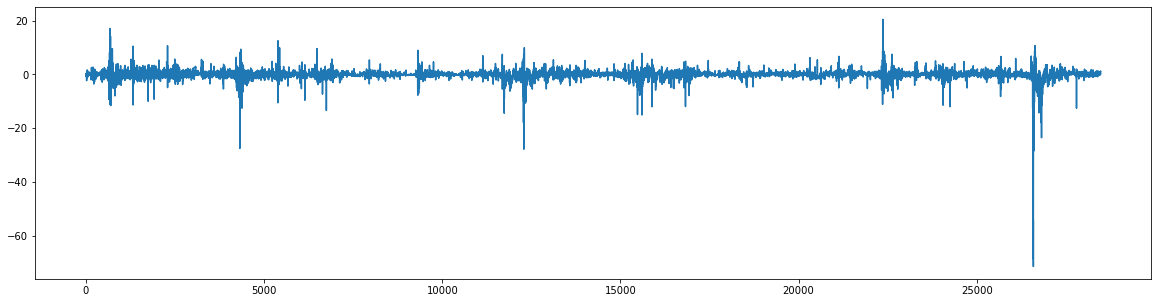

         time  action      cost  comment
0  1636577520       0 -0.349990        0
1  1637254620       1  0.281868        2
2  1637915820       0 -0.280361        0
3  1637945880       1  0.293394        1
-0.1749669258964344


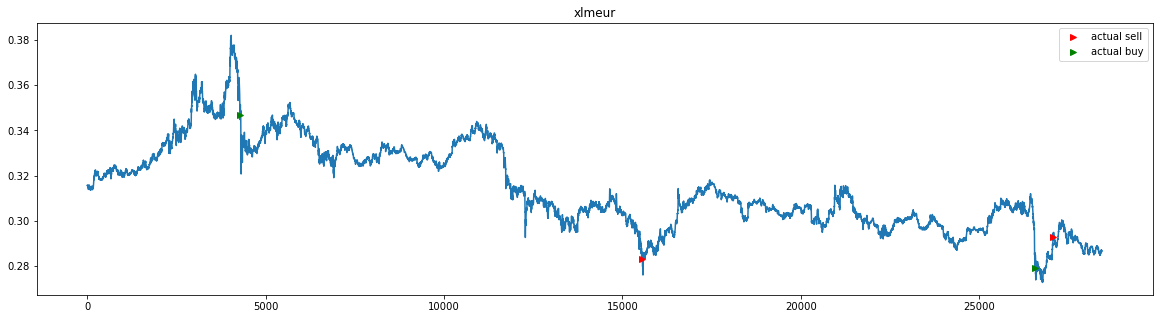

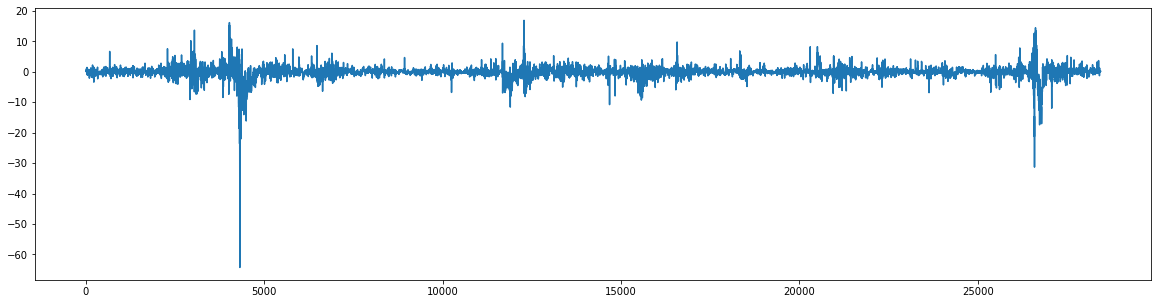

In [21]:
list_acc=[]
for pair_name in crypto_to_evaluate+crypto_to_optimize:
    df_backtest = df[df.pair_name==pair_name]
    actions = backtest_numba(
        indexes= df_backtest.time.values,
        open_values=df_backtest.open.values,
        preds_values=df_backtest.preds.values,
        **study.best_params
    )
    actions_df = pd.DataFrame(actions, columns=["time", "action", "cost", "comment"])
    df_backtest = df_backtest.merge(actions_df, how="left", on="time")
    print(actions_df)
    print(actions_df.cost.sum()/df_backtest.open.mean())
    list_acc.append(actions_df.cost.sum()/df_backtest.open.mean())
    plt.figure(figsize=(20,5))
    plt.plot(df_backtest.open)
    plt.plot(df_backtest[df_backtest.action==1].open, ">r", label="actual sell")
    plt.plot(df_backtest[df_backtest.action==0].open, ">g", label="actual buy")
    plt.legend()
    plt.title(pair_name)
    plt.show()

    plt.figure(figsize=(20,5))
    plt.plot(df_backtest.preds)
    plt.show()

In [22]:
np.array(list_acc).mean()

-0.015843927209573474

In [ ]:
1638029100

In [76]:
df_backtest

,index,Unnamed: 0,date,time,open,high,low,close,vwap,volume,...,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37,type,pair_name,preds,action,cost,comment
0,59884,59884,2021-11-07 21:29:00,1636320540,0.85633,0.85633,0.85633,0.85633,0.00000,0.000000,...,-0.004360,-0.007683,-0.006889,-0.009554,training,bateur,-0.302413,NaN,NaN,NaN
1,59885,59885,2021-11-07 21:30:00,1636320600,0.85633,0.85633,0.85633,0.85633,0.00000,0.000000,...,-0.004360,-0.007683,-0.005447,-0.008820,training,bateur,-0.302413,NaN,NaN,NaN
2,59886,59886,2021-11-07 21:31:00,1636320660,0.85633,0.85633,0.85633,0.85633,0.00000,0.000000,...,-0.004360,-0.005077,-0.006117,-0.008820,training,bateur,-0.192994,NaN,NaN,NaN
3,59887,59887,2021-11-07 21:32:00,1636320720,0.85892,0.85892,0.85892,0.85892,0.85892,32.877090,...,-0.001349,-0.001058,-0.003110,-0.005822,training,bateur,-0.121280,NaN,NaN,NaN
4,59888,59888,2021-11-07 21:33:00,1636320780,0.85892,0.85892,0.85892,0.85892,0.00000,0.000000,...,-0.001349,-0.000116,-0.003110,-0.007603,training,bateur,-0.198771,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28220,88104,88104,2021-11-27 16:01:00,1638028860,1.39623,1.39623,1.39623,1.39623,0.00000,0.000000,...,-0.026332,-0.024536,0.034030,0.023171,validation_unseen,bateur,-5.432810,NaN,NaN,NaN
28221,88105,88105,2021-11-27 16:02:00,1638028920,1.40558,1.40558,1.40026,1.40026,1.40129,1259.799860,...,-0.023062,-0.015183,0.040947,0.032725,validation_unseen,bateur,3.772877,NaN,NaN,NaN
28222,88106,88106,2021-11-27 16:03:00,1638028980,1.40030,1.40030,1.40030,1.40030,1.40030,9.648844,...,-0.029046,-0.023623,0.037036,0.028558,validation_unseen,bateur,-9.953026,0.0,-1.405901,0.0
28223,88107,88107,2021-11-27 16:04:00,1638029040,1.40030,1.40030,1.40030,1.40030,0.00000,0.000000,...,-0.029046,-0.028244,0.037036,0.034623,validation_unseen,bateur,-7.613456,NaN,NaN,NaN


Is there any shift in the preds?

In [38]:
df_all["preds"] = model.predict(df_all[columns_features])

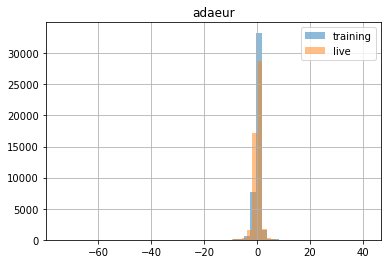

41.003013610839844 18.316078186035156
-68.12594604492188 -73.961181640625


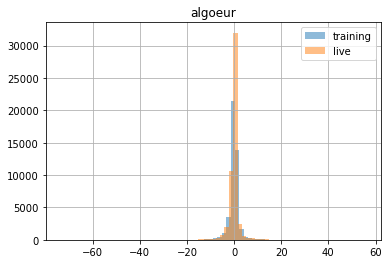

55.78840255737305 20.190462112426758
-36.6625862121582 -73.30679321289062


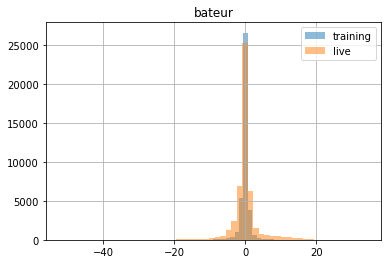

33.92377853393555 25.436843872070312
-27.53054428100586 -51.76688003540039


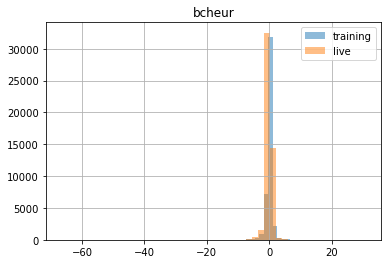

30.880380630493164 29.010961532592773
-40.17288589477539 -66.65035247802734


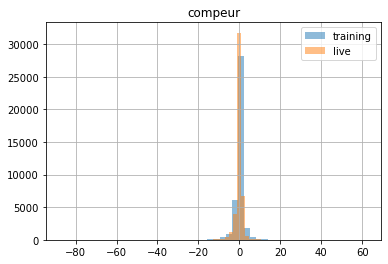

61.609928131103516 22.650054931640625
-86.94591522216797 -76.60980987548828


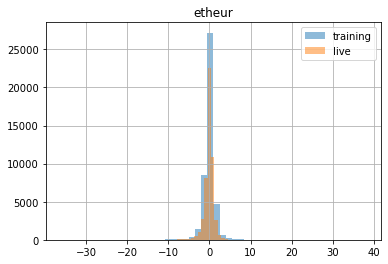

37.94896697998047 17.69490623474121
-36.00285339355469 -23.506309509277344


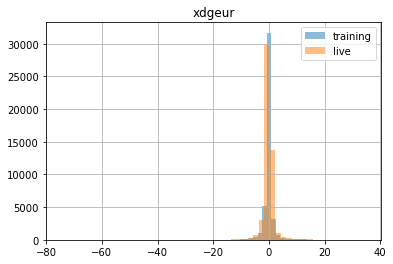

34.79174041748047 23.921836853027344
-45.8569450378418 -74.60064697265625


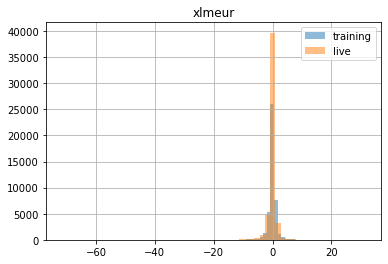

31.68478775024414 16.9257869720459
-28.267833709716797 -71.84928131103516


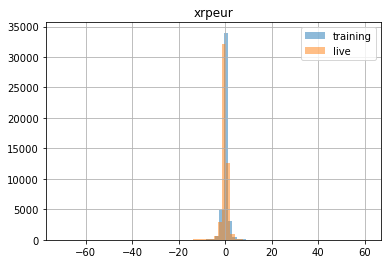

60.43695831298828 18.19386100769043
-35.18070983886719 -70.615478515625


In [39]:
cut_off_date ="2021-10-23 21:28:00"
for name, df_group in df_all.groupby("pair_name"):
    plt.figure()
    plt.title(name)
    df_group[df_group.date<cut_off_date].preds.hist(bins=50, alpha=0.5)
    df_group[df_group.date>cut_off_date].preds.hist(bins=50, alpha=0.5)
    plt.legend(["training", "live"])
    plt.show()
    print(df_group[df_group.date<cut_off_date].preds.max(),df_group[df_group.date>cut_off_date].preds.max() )
    print(df_group[df_group.date<cut_off_date].preds.min(),df_group[df_group.date>cut_off_date].preds.min() )

In [35]:
study.best_params, study.best_value

({'take_profit_pct': 0.05020948792381168,
  'stop_loss_pct': 0.33024334643667014,
  'lim_pred_sell': 9.712542912230221,
  'lim_pred_buy': -0.30959679273590357},
 0.11261156631209349)

In [133]:

import numpy as np
np.array([1,2]).mean()

1.5

In [11]:
df["preds"] = model.predict(df[columns_features])

In [27]:
crypto_to_evaluate

['etheur', 'algoeur', 'bateur', 'adaeur', 'xrpeur']

In [21]:
df_test = df[df.pair_name=="xlmeur"].copy()

In [22]:
strategy = Strategy(**study.best_params)
strategy = Strategy(**{'take_profit_pct': 0.04,
  'stop_loss_pct': 0.04,
  'lim_pred_sell': 3,
  'lim_pred_buy': -3})

In [23]:
df_backtest = strategy.backtest(df_test[["open", "preds"]])

In [26]:
#%time df_backtest = strategy.backtest(df_test)

In [16]:
#for market_action_pct in [0.01,0.02,0.03, 0.04, 0.05, 1]:
#    strategy = Strategy(take_profit_pct=market_action_pct, stop_loss_pct=market_action_pct, security_factor=0.000)
#    df_backtest = strategy.backtest(df_test)
#    profit = df_backtest["cost"].sum()/df_backtest["open"].mean()
#    hist_ratio = df_backtest.tail(1).open.values[0]/df_backtest.head(1).open.values[0]-1
#    print("stop and take", market_action_pct)
#    print("profit and hist", profit," and ",  hist_ratio)
#    print(df_backtest.strategy_action.value_counts())
    #print(df_backtest.comment.value_counts())

In [26]:
df_backtest[df_backtest.cost.notnull()]

,open,preds,predicted_action,strategy_action,comment,cost
67447,0.329869,-4.136318,buy,buy,buy_predicted,-0.331188
67586,0.344000,2.196841,None,sell,take_profit_triggered,0.342624
67656,0.333295,-4.641719,buy,buy,buy_predicted,-0.334628
68078,0.347243,-2.022429,None,sell,take_profit_triggered,0.345854
68079,0.348203,-3.430486,buy,buy,buy_predicted,-0.349596
68145,0.362500,2.869562,None,sell,take_profit_triggered,0.36105
68146,0.361726,-4.169470,buy,buy,buy_predicted,-0.363173
68678,0.347021,0.672411,None,sell,stop_loss_triggered,0.345633
68994,0.349480,-3.137535,buy,buy,buy_predicted,-0.350878
69131,0.363763,0.651548,None,sell,take_profit_triggered,0.362308


In [ ]:
import pandas as pd
class Strategy:
    def __init__(
        self,
        take_profit_pct: float = 0,
        stop_loss_pct:float=0,
        wait_time_after_action: int=0,
        pred_column_name: str="preds",
        lim_pred_sell: float=3,
        lim_pred_buy:float=-3,
        security_factor:float=0.0024
):
        self.take_profit_pct=take_profit_pct
        self.stop_loss_pct=stop_loss_pct
        self.wait_time_after_action=wait_time_after_action
        self.pred_column_name=pred_column_name
        self.lim_pred_sell=lim_pred_sell
        self.lim_pred_buy=lim_pred_buy
        self.fee=0.0016
        self.security_factor=security_factor
        
    def backtest(self, df: pd.DataFrame):
        df = df.copy()
        if self.pred_column_name not in df.columns:
            raise KeyError(f"{self.pred_column_name} not in columns")
        # asign action to predicted_action column
        df = self._add_predicted_action(df)
        # asign take profit or stop loss
        df["strategy_action"] = None
        df["comment"] = None
        df["cost"] = None
        next_action = "buy"
        previous_price = 0

        for index, row in df.iterrows():
            if (row["open"]>(1+self.take_profit_pct)*previous_price) and next_action=="sell":
                df.loc[df.index==index,"strategy_action"] = "sell"
                df.loc[df.index==index,"cost"] = row["open"]*(1-self.fee-self.security_factor)
                df.loc[df.index==index,"comment"] = "take_profit_triggered"
                next_action = "buy"
                previous_price = row["open"]
            
            elif (row["open"]<(1-self.stop_loss_pct)*previous_price) and next_action=="sell":
                df.loc[df.index==index,"strategy_action"] = "sell"
                df.loc[df.index==index,"cost"] = row["open"]*(1-self.fee-self.security_factor) #-row["open"]*(1+self.fee+self.security_factor)
                df.loc[df.index==index,"comment"] = "stop_loss_triggered"
                next_action = "buy"
                previous_price = row["open"]
            elif row["predicted_action"]=="buy" and next_action=="buy":
                df.loc[df.index==index,"strategy_action"] = "buy"
                df.loc[df.index==index,"cost"] = -row["open"]*(1+self.fee+self.security_factor)
                df.loc[df.index==index,"comment"] = "buy_predicted"
                next_action = "sell"
                previous_price = row["open"]
                
        df = self._equalize_buys_and_sells(df)

        return df
    def _add_predicted_action(self,df):
        df["predicted_action"] = None
        df.loc[df[self.pred_column_name]>self.lim_pred_sell, "predicted_action"] = "sell"
        df.loc[df[self.pred_column_name]<self.lim_pred_buy, "predicted_action"] = "buy"
        return df
    
    def _equalize_buys_and_sells(self, df):
        if df[df.strategy_action.notnull()].tail(1).strategy_action.values[0]=="buy":
            df.loc[df[df.strategy_action.notnull()].tail(1).index, ["cost", "strategy_action"]] = None
        return df
        
    

In [51]:
df_backtest["cost"].sum()

0.9838294000000016

In [15]:
print("sum", df_backtest.cost.sum())
print(df_backtest.strategy_action.value_counts())

sum 1.14181812
buy     19
sell    19
Name: strategy_action, dtype: int64


In [53]:
df_backtest[df_backtest.cost.notnull()][["open", "comment", "strategy_action", "cost"]]

,open,comment,strategy_action,cost
509292,1.61331,buy_predicted,buy,-1.61976
510261,1.70500,take_profit_triggered,sell,1.69818
510270,1.67446,buy_predicted,buy,-1.68116
510519,1.79040,take_profit_triggered,sell,1.78324
510521,1.78097,buy_predicted,buy,-1.78809
513263,1.87760,take_profit_triggered,sell,1.87009
513273,1.87116,buy_predicted,buy,-1.87864
513314,1.98299,take_profit_triggered,sell,1.97506
513322,1.91745,buy_predicted,buy,-1.92512
516164,2.02839,take_profit_triggered,sell,2.02028


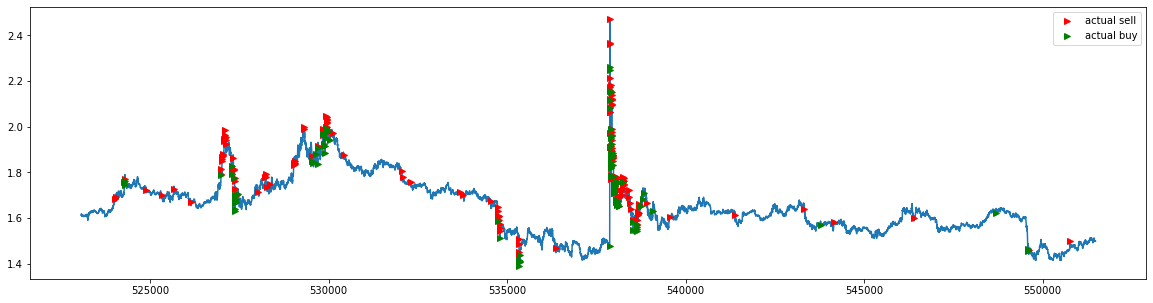

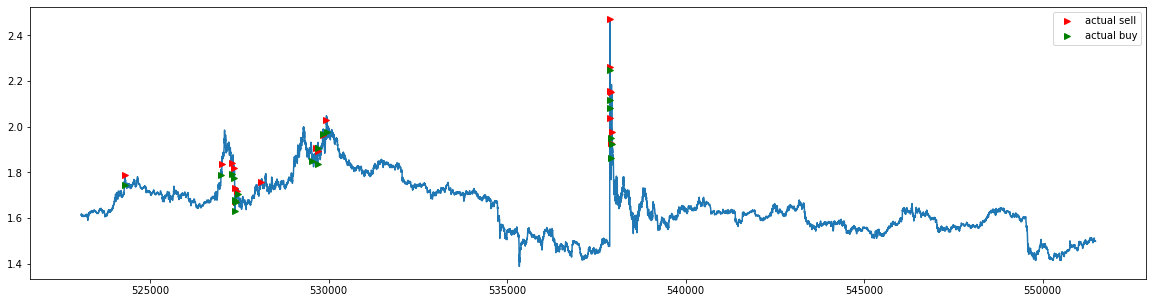

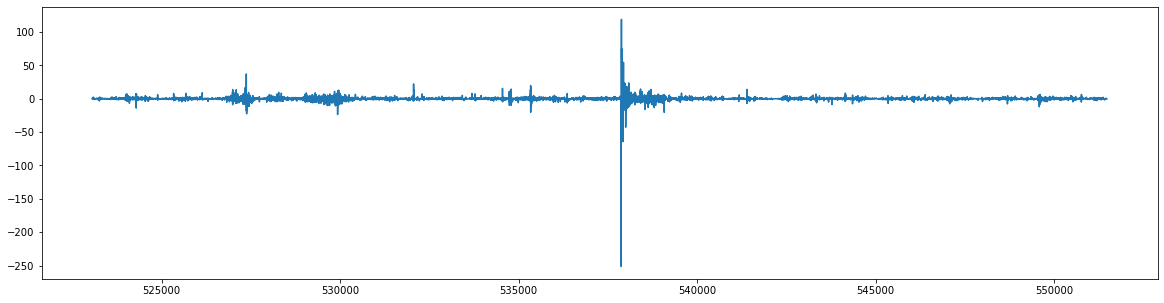

In [16]:
plt.figure(figsize=(20,5))
plt.plot(df_backtest.open)
plt.plot(df_backtest[df_backtest.predicted_action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtest[df_backtest.predicted_action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtest.open)
plt.plot(df_backtest[df_backtest.strategy_action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtest[df_backtest.strategy_action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtest.preds)
plt.show()

<AxesSubplot:>

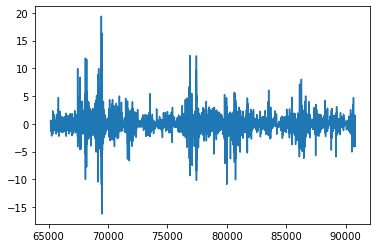

In [49]:
df_backtest.preds.plot()